# CASEN 2022 — Indicator exploration

Exploration of indicators from Chile's [Encuesta de Caracterización Socioeconómica Nacional (CASEN) 2022](https://observatorio.ministeriodesarrollosocial.gob.cl/encuesta-casen). The data supports:

- **Median household income** — Total corrected household income
- **Poverty rate** — Share of population in poverty (by income)
- **Unemployment rate** — Share of labor force unemployed
- **Public transport commute share** — Share of workers using public transport for commute

## 1. Loading from source

When you download the CASEN 2022 microdata (`.sav` format) from the [official source](https://observatorio.ministeriodesarrollosocial.gob.cl/encuesta-casen), use the code below to load it. **The full file is ~1.3 GB and is not included in this repository.** Using `usecols` keeps memory use down by loading only the variables needed for these indicators.

In [4]:
# import pyreadstat

# # Columns needed for your 4 indicators
# usecols = [
#     'folio', 'hogar',       # household IDs
#     'expr',                  # expansion factor (weights)
#     'ytotcorh',              # median household income
#     'pobreza',               # poverty rate (1=extrema, 2=no extrema, 3=no pobre)
#     'activ',                 # unemployment (1=ocupado, 2=desocupado, 3=inactivo)
#     'o28c',                  # public transport commute (1=transporte público)
#     'region', 'area',        # optional: geography
# ]

# df, meta = pyreadstat.read_sav('casen_2022.sav', usecols=usecols)
# print(df.shape)

For exploration in this repository, we use a pre-extracted sample (`casen_2022.csv`) containing the required columns. National-level indicator estimates:

In [5]:
import pandas as pd
import numpy as np

df = pd.read_csv('../sample/casen_2022.csv')

# 1. Median household income – one row per household, median of ytotcorh
hh = df.drop_duplicates(subset=['folio'])
median_income = np.median(hh['ytotcorh'].dropna())
# Weighted median (using expr):
# from statsmodels.stats.weightstats import DescrStatsW
# wmedian = DescrStatsW(hh['ytotcorh'], weights=hh['expr']).quantile(0.5)

# 2. Poverty rate – % with pobreza 1 or 2 (use weights)
poor = df['pobreza'].isin([1, 2])
poverty_rate = (df.loc[poor, 'expr'].sum() / df['expr'].sum()) * 100

# 3. Unemployment rate – desocupados / labor force (activ 1 or 2)
labor_force = df['activ'].isin([1, 2])
unemployed = df['activ'] == 2
unemp_rate = (df.loc[unemployed, 'expr'].sum() / df.loc[labor_force, 'expr'].sum()) * 100

# 4. Public transport commute share – o28c==1 among workers who report transport
has_transport = df['o28c'].notna()
public_transport = df['o28c'] == 1
pt_share = (df.loc[has_transport & public_transport, 'expr'].sum() 
            / df.loc[has_transport, 'expr'].sum()) * 100

print(f"Median household income: {median_income:,.0f}")
print(f"Poverty rate: {poverty_rate:.1f}%")
print(f"Unemployment rate: {unemp_rate:.1f}%")
print(f"Public transport commute share: {pt_share:.1f}%")

Median household income: 983,333
Poverty rate: 20.5%
Unemployment rate: 8.6%
Public transport commute share: 38.5%


## 2. Transformation to curated format

A DuckDB query transforms the sample into `curated_data.csv` with the same schema as the Censo 2024 sample: `region`, `comuna`, `region_nombre`, `comuna_nombre`, `attribute_type`, `attribute_value`, `attribute_units`.

The query reads `casen_2022.csv` and `location_id.csv`, computes the four indicators by region (weighted with `expr`), expands to comuna level via the location lookup, and unpivots to the long format.

In [6]:
import duckdb

SAMPLE_DIR = "../sample"

curated = duckdb.query("""
WITH
loc AS (
  SELECT
    CAST(region AS INTEGER) AS region,
    region_name AS region_nombre,
    CAST(comuna AS INTEGER) AS comuna,
    comuna_name AS comuna_nombre
  FROM read_csv_auto(?)
),
casen AS (
  SELECT
    CAST(folio AS BIGINT) AS folio,
    CAST(region AS INTEGER) AS region,
    CAST(expr AS DOUBLE) AS expr,
    CAST(ytotcorh AS DOUBLE) AS ytotcorh,
    CAST(pobreza AS DOUBLE) AS pobreza,
    CAST(activ AS DOUBLE) AS activ,
    CAST(o28c AS DOUBLE) AS o28c
  FROM read_csv_auto(?)
),
hh AS (
  SELECT folio, region, ytotcorh
  FROM (
    SELECT folio, region, ytotcorh,
           row_number() OVER (PARTITION BY folio ORDER BY 1) AS rn
    FROM casen
  )
  WHERE rn = 1
),
by_region AS (
  SELECT
    c.region,
    ROUND(MEDIAN(h.ytotcorh), 2) AS median_household_income,
    ROUND(100.0 * SUM(CASE WHEN c.pobreza IN (1, 2) THEN c.expr ELSE 0 END)
         / NULLIF(SUM(c.expr), 0), 2) AS poverty_rate,
    ROUND(100.0 * SUM(CASE WHEN c.activ = 2 THEN c.expr ELSE 0 END)
         / NULLIF(SUM(CASE WHEN c.activ IN (1, 2) THEN c.expr ELSE 0 END), 0), 2) AS unemployment_rate,
    ROUND(100.0 * SUM(CASE WHEN c.o28c = 1 THEN c.expr ELSE 0 END)
         / NULLIF(SUM(CASE WHEN c.o28c IS NOT NULL THEN c.expr ELSE 0 END), 0), 2) AS public_transport_share
  FROM casen c
  LEFT JOIN hh h ON c.folio = h.folio
  GROUP BY c.region
),
cut AS (
  SELECT l.region, l.comuna, l.region_nombre, l.comuna_nombre
  FROM loc l
  WHERE l.region IN (SELECT region FROM by_region)
),
expanded AS (
  SELECT e.*, b.median_household_income, b.poverty_rate, b.unemployment_rate, b.public_transport_share
  FROM cut e
  JOIN by_region b ON e.region = b.region
)
SELECT region, comuna, region_nombre, comuna_nombre, attribute_type, attribute_value, attribute_units
FROM (
  SELECT region, comuna, region_nombre, comuna_nombre, 'median_household_income' AS attribute_type, median_household_income AS attribute_value, 'CLP' AS attribute_units FROM expanded
  UNION ALL
  SELECT region, comuna, region_nombre, comuna_nombre, 'poverty_rate', poverty_rate, 'percent' FROM expanded
  UNION ALL
  SELECT region, comuna, region_nombre, comuna_nombre, 'unemployment_rate', unemployment_rate, 'percent' FROM expanded
  UNION ALL
  SELECT region, comuna, region_nombre, comuna_nombre, 'public_transport_share', public_transport_share, 'percent' FROM expanded
)
ORDER BY region, comuna, attribute_type
""", params=[f"{SAMPLE_DIR}/location_id.csv", f"{SAMPLE_DIR}/casen_2022.csv"]).df()

curated.to_csv(f"{SAMPLE_DIR}/curated_data.csv", index=False)
print(f"Wrote {len(curated)} rows to {SAMPLE_DIR}/curated_data.csv")
curated.head(12)

Wrote 1384 rows to ../sample/curated_data.csv


,region,comuna,region_nombre,comuna_nombre,attribute_type,attribute_value,attribute_units
0,1,1101,Región de Tarapacá,Iquique,median_household_income,1201859.00,CLP
1,1,1101,Región de Tarapacá,Iquique,poverty_rate,26.77,percent
2,1,1101,Región de Tarapacá,Iquique,public_transport_share,31.84,percent
3,1,1101,Región de Tarapacá,Iquique,unemployment_rate,9.44,percent
4,1,1107,Región de Tarapacá,Alto Hospicio,median_household_income,1201859.00,CLP
5,1,1107,Región de Tarapacá,Alto Hospicio,poverty_rate,26.77,percent
6,1,1107,Región de Tarapacá,Alto Hospicio,public_transport_share,31.84,percent
7,1,1107,Región de Tarapacá,Alto Hospicio,unemployment_rate,9.44,percent
8,1,1401,Región de Tarapacá,Pozo Almonte,median_household_income,1201859.00,CLP
9,1,1401,Región de Tarapacá,Pozo Almonte,poverty_rate,26.77,percent


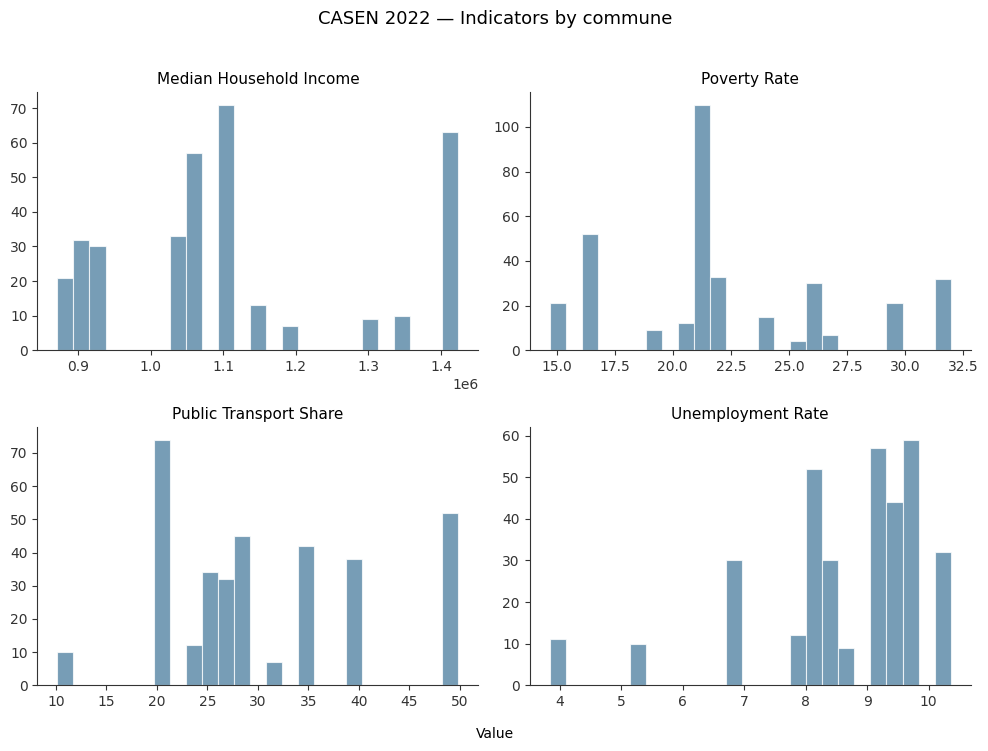

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../sample/curated_data.csv")

# Minimal style
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "#333",
    "axes.linewidth": 0.8,
    "grid.color": "#e0e0e0",
    "grid.alpha": 0.7,
    "xtick.color": "#333",
    "ytick.color": "#333",
    "font.size": 10,
})

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for i, attr in enumerate(df["attribute_type"].unique()):
    ax = axes[i]
    data = df.loc[df["attribute_type"] == attr, "attribute_value"]
    ax.hist(data, bins=25, color="#4a7c9e", alpha=0.75, edgecolor="white", linewidth=0.8)
    ax.set_title(attr.replace("_", " ").title(), fontsize=11)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

fig.suptitle("CASEN 2022 — Indicators by commune", fontsize=13, y=1.02)
fig.text(0.5, -0.02, "Value", ha="center", fontsize=10)
plt.tight_layout()
plt.show()